# Deep Learning for Health Outcome Prediction

This notebook explores the use of fully connected neural networks for predicting health outcomes using the same dataset as previous analyses. Model behavior is examined across increasing levels of complexity, with particular focus on overfitting, regularization, and generalization.

Training dynamics are analyzed using learning curves and validation metrics, and multiple regularization strategies are evaluated to improve model performance.

## Dataset and Preprocessing

The dataset used in this analysis is the cleaned version produced in the previous machine learning assignment. All preprocessing steps, including feature selection, normalization, and encoding, were completed prior to model training.

- [alien_pet_health-realism-clean.csv](https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean.csv)

Data was split into training and validation subsets, and preprocessing operations were applied in a leakage-aware manner.

In [ ]:
import os
from pathlib import Path
import urllib.request
import urllib.error

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from keras.metrics import F1Score

In [2]:
URL_DATA = "https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean.csv"

COLS_TO_STANDARDIZE = ["thermoreg_reading", "enzyme_activity_index", "stress_variability"]
COLS_TO_NORMALIZE = ["dual_lobe_signal"]
COLS_TO_ENCODE = ["habitat_zone"]
COLS_NO_PREPROC = ["activity_score","fasting_flag"]
TARGET   = "health_outcome"

COLUMNS_DATA = COLS_TO_STANDARDIZE + COLS_TO_NORMALIZE + COLS_TO_ENCODE + COLS_NO_PREPROC

RANDOM_STATE = 42
TEST_SIZE    = 0.20

SCORING = {
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
    "roc_auc": "roc_auc",
}

PRIMARY_METRIC = F1Score(threshold=0.5, average="macro")

In [3]:
def load_dataset_or_fail(url=URL_DATA, cache_dir="data", *, verbose=True):

    """
    Load the dataset, downloading it once and caching locally.

    - Extracts the filename from the URL.
    - Stores it under `cache_dir`.
    - Validates required columns and target.

    Returns
    -------
    X : pandas.DataFrame
    y : numpy.ndarray
    """

    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(url).name
    cache_path = cache_dir / filename

    # 1) Download if not cached

    if not cache_path.exists():
        if verbose:
            print(f"Downloading dataset from {url} ...")
        try:
            urllib.request.urlretrieve(url, cache_path)
            if verbose:
                print(f"Saved to {cache_path}")
        except (urllib.error.URLError, urllib.error.HTTPError) as e:
            raise RuntimeError(f"Failed to download dataset: {e}")

    # 2) Read the CSV

    try:
        df = pd.read_csv(cache_path)
    except Exception as e:
        raise RuntimeError(f"Failed to read {cache_path}: {e}")

    # 3) Validate content

    if TARGET not in df.columns:
        raise ValueError(f"Missing target column '{TARGET}' in {cache_path}")

    df = df.dropna(subset=[TARGET]).copy()

    missing = set(COLUMNS_DATA).difference(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {cache_path}: {sorted(missing)}")

    # 4) Split features and target

    X = df[COLUMNS_DATA]
    y = df[TARGET].astype(int).to_numpy().reshape(-1,1) # (n,) -> (n,1)

    return X, y

In [4]:
def set_seed(seed: int = 42):
    
    """Fix most randomness sources for reproducible demos."""

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [5]:
set_seed(42)

## Approach

**Dataset Loading and Initial Inspection**

The dataset is loaded into a pandas DataFrame and is inspected to understand its dimensionality and a sample of its records.

In [6]:
# Python code

X, y = load_dataset_or_fail(URL_DATA)
print(X.shape)
print(y.shape)
display(X.describe())
X.head()

(5000, 7)
(5000, 1)


,thermoreg_reading,enzyme_activity_index,stress_variability,dual_lobe_signal,activity_score,fasting_flag
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,50.000140,100.005800,0.000580,2.001180,2.967200,0.401800
std,8.000065,29.989012,5.000697,3.000172,1.290138,0.490311
min,21.000000,0.000000,-18.000000,-6.500000,1.000000,0.000000
25%,44.600000,80.000000,-3.400000,-0.400000,2.000000,0.000000
50%,50.100000,100.000000,0.000000,2.500000,3.000000,0.000000
75%,55.200000,120.000000,3.425000,4.500000,4.000000,1.000000
max,77.800000,231.000000,18.700000,8.900000,5.000000,1.000000


,thermoreg_reading,enzyme_activity_index,stress_variability,dual_lobe_signal,habitat_zone,activity_score,fasting_flag
0,52.6,97.0,-3.5,3.6,c2,2,0
1,41.8,105.0,10.5,3.4,c1,2,0
2,56.2,126.0,9.6,5.5,c2,5,0
3,57.7,106.0,-4.0,-4.1,c1,4,0
4,34.5,73.0,0.3,2.3,c4,5,1


**Data splitting**

Split the dataset into training (70%), validation (15%) and test (15%) sets. Ensure that this split occurs before any preprocessing to avoid data leakage.

In [7]:
# Python code

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)


### Data Pre-Processing

In [8]:
# Python code

def make_preprocessor(COLS_TO_STANDARDIZE, COLS_TO_NORMALIZE, COLS_TO_ENCODE, COLS_NO_PREPROC):

    """
    Build a ColumnTransformer for the Alien Pet Health dataset.

    - Standardizes selected columns (zero mean, unit variance)
    - Normalizes selected columns to [0,1]
    - One-hot encodes categorical columns
    - Passes specified columns through unchanged

    Note: Columns in COLS_NO_PREPROC must already be numeric (e.g., 0/1 flags).
    """

    preprocessor = ColumnTransformer(
        transformers=[
            ("standardize", StandardScaler(), COLS_TO_STANDARDIZE),
            ("normalize", MinMaxScaler(), COLS_TO_NORMALIZE),
            ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False), COLS_TO_ENCODE),
            ("keep", "passthrough", COLS_NO_PREPROC),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    return preprocessor

def fit_transform_inputs(preprocess: ColumnTransformer, X_train: pd.DataFrame, 
                         X_val: pd.DataFrame, X_test: pd.DataFrame):

    """
    Fit the preprocessor on train; transform train/val/test consistently.
    Returns numpy arrays and input_dim for Keras.
    """

    Xtr = preprocess.fit_transform(X_train)
    Xva = preprocess.transform(X_val)
    Xte = preprocess.transform(X_test)
    input_dim = Xtr.shape[1]

    return Xtr, Xva, Xte, input_dim

In [9]:
# Python code

preprocess = make_preprocessor(COLS_TO_STANDARDIZE, COLS_TO_NORMALIZE, COLS_TO_ENCODE, COLS_NO_PREPROC)

Xtr, Xva, Xte, input_dim = fit_transform_inputs(preprocess, X_train, X_val, X_test)

### Baseline Neural Network

A simple feed-forward neural network with a single hidden layer was trained to establish baseline performance. The model used ReLU activation in the hidden layer and a sigmoid output for binary classification.

Training and validation loss and F1-score were monitored over epochs to assess model fit and learning behavior.


In [10]:
# Build model

def build_model(input_dim, layer_units, activation='relu'):
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_dim,))) # first hidden layer, needs input dim
    # units = number of neurons in layer
    for units in layer_units: # other hidden layers: idx 1 to rest
        model.add(keras.layers.Dense(units, activation=activation))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[PRIMARY_METRIC]
    )
    return model

# Train model

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history

# Plot history

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = range(1, len(hist) + 1)

    f1_key = next((k for k in hist.columns if 'f1' in k and not k.startswith('val_')), None)
    val_f1_key = next((k for k in hist.columns if 'val_f1' in k), None)

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    
    sns.lineplot(data=hist, x='epoch', y='loss', ax=ax[0], label='train')
    sns.lineplot(data=hist, x='epoch', y='val_loss', ax=ax[0], label='val')
    ax[0].set_title('Training vs Validation Loss')

    if f1_key and val_f1_key:
        sns.lineplot(data=hist, x='epoch', y=f1_key, ax=ax[1], label='train')
        sns.lineplot(data=hist, x='epoch', y=val_f1_key, ax=ax[1], label='val')
        ax[1].set_title('Training vs Validation F1 Score')
    else:
        ax[1].text(0.5, 0.5, 'No F1 metric found', ha='center')

    plt.tight_layout()
    plt.show()


# Evaluate model

def evaluate_model(model, X, y):
    prob = model.predict(X).ravel()
    pred = (prob >= 0.5).astype(int)

    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    f1 = f1_score(y, pred)
    auc = roc_auc_score(y, prob)

    print(f'Precision: {precision:.3f}')
    print(f'Recall:    {recall:.3f}')
    print(f'F1 Score:  {f1:.3f}')
    print(f'ROC AUC:   {auc:.3f}')

    return precision, recall, f1, auc


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6623 - loss: 0.8188 - val_f1_score: 0.6537 - val_loss: 0.7156
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - f1_score: 0.6429 - loss: 0.6814 - val_f1_score: 0.6513 - val_loss: 0.6540
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - f1_score: 0.6755 - loss: 0.6327 - val_f1_score: 0.6905 - val_loss: 0.6082
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - f1_score: 0.7107 - loss: 0.5903 - val_f1_score: 0.7168 - val_loss: 0.5695
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - f1_score: 0.7424 - loss: 0.5538 - val_f1_score: 0.7495 - val_loss: 0.5366
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - f1_score: 0.7635 - loss: 0.5225 - val_f1_score: 0.7661 - val_loss: 0.5077
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - f1_score: 0.7810 - loss: 0.4954 - val_f1_score: 0.7807 - val_loss: 0.4824
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - f1_score: 0.7913 - loss: 0.4

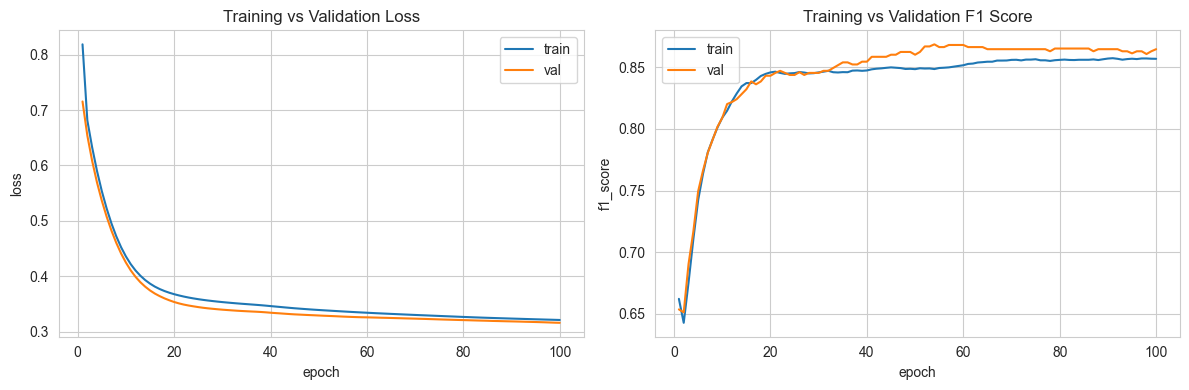

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.849
Recall:    0.880
F1 Score:  0.864
ROC AUC:   0.938


(0.8494208494208494, 0.88, 0.8644400785854617, 0.93776)

In [11]:
# Simple FFN

model = build_model(input_dim=input_dim, layer_units=[8])
history = train_model(model, Xtr, y_train, Xva, y_val, epochs=100)
plot_history(history)
evaluate_model(model, Xva, y_val)

**Overfitting or Underfitting**

The model does not underfit or overfit. This is because the training and validation losses are low and similar, F1 curves converge closely, and validation metrics are high.
If it were to overfit, the validation loss would be much higher/rising while training loss falls.
If it were to underfit, losses for both would remain high, and f1 scores would be lower.

### Overfitting

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.8175 - loss: 0.4648 - val_f1_score: 0.8620 - val_loss: 0.3459
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - f1_score: 0.8438 - loss: 0.3503 - val_f1_score: 0.8702 - val_loss: 0.3134
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - f1_score: 0.8565 - loss: 0.3274 - val_f1_score: 0.8709 - val_loss: 0.2976
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - f1_score: 0.8675 - loss: 0.3098 - val_f1_score: 0.8812 - val_loss: 0.2854
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - f1_score: 0.8723 - loss: 0.2966 - val_f1_score: 0.8803 - val_loss: 0.2749
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - f1_score: 0.8765 - loss: 0.2848 - val_f1_score: 0.8820 - val_loss: 0.2682
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - f1_score: 0.8829 - loss: 0.2763 - val_f1_score: 0.8846 - val_loss: 0.2646
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - f1_score: 0.8847 - loss: 0.2

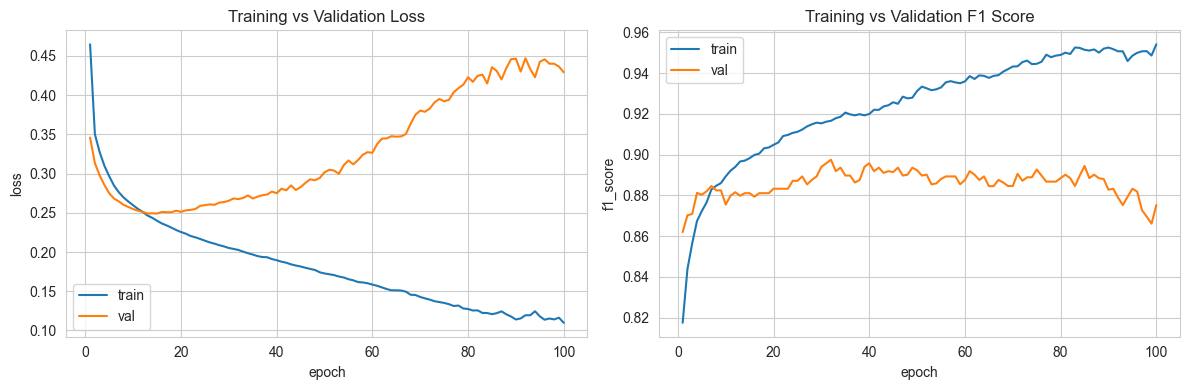

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.867
Recall:    0.884
F1 Score:  0.875
ROC AUC:   0.953


(0.8666666666666667, 0.884, 0.8752475247524752, 0.952656)

In [12]:
# Visible overfitting

model_overfit = build_model(input_dim=input_dim, layer_units=[128, 64, 32])
history_overfit = train_model(model_overfit, Xtr, y_train, Xva, y_val, epochs=100)
plot_history(history_overfit)
evaluate_model(model_overfit, Xva, y_val)

**Overfitting Behavior**

Model complexity was intentionally increased to induce overfitting. As expected, training performance continued to improve while validation performance degraded, indicating that the model began memorizing training patterns rather than learning generalizable structure.

This behavior was clearly reflected in diverging learning curves and declining validation metrics.


### Early Stopping

Early stopping was introduced to mitigate overfitting by halting training when validation performance ceased to improve. This approach prevented unnecessary training iterations and restored the model weights corresponding to the best observed validation performance.

Learning curves demonstrate improved generalization and reduced divergence between training and validation metrics.

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.7915 - loss: 0.4948 - val_f1_score: 0.8436 - val_loss: 0.3581
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - f1_score: 0.8397 - loss: 0.3540 - val_f1_score: 0.8750 - val_loss: 0.3089
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - f1_score: 0.8550 - loss: 0.3257 - val_f1_score: 0.8757 - val_loss: 0.2897
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - f1_score: 0.8636 - loss: 0.3085 - val_f1_score: 0.8806 - val_loss: 0.2762
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - f1_score: 0.8712 - loss: 0.2964 - val_f1_score: 0.8828 - val_loss: 0.2672
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - f1_score: 0.8776 - loss: 0.2873 - val_f1_score: 0.8872 - val_loss: 0.2615
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - f1_score: 0.8790 - loss: 0.2802 - val_f1_score: 0.8828 - val_loss: 0.2591
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - f1_score: 0.8817 - loss: 0.2

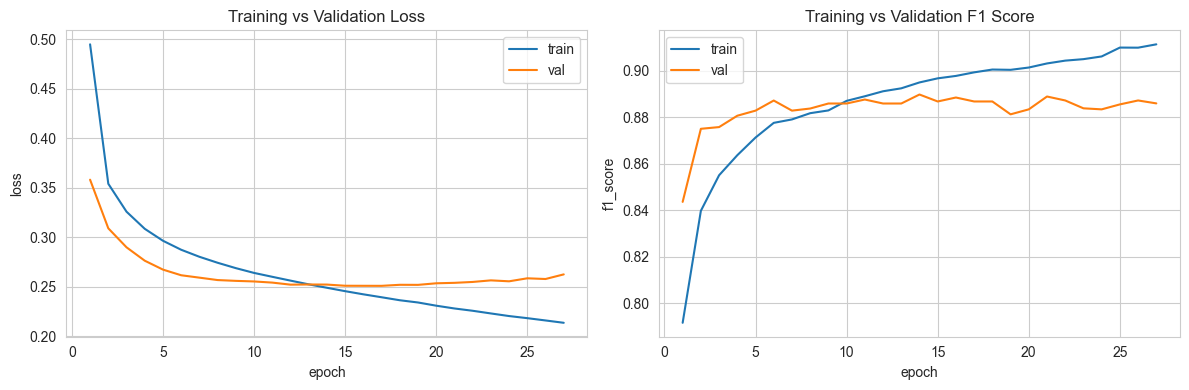

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.852
Recall:    0.924
F1 Score:  0.887
ROC AUC:   0.964


(0.8523985239852399, 0.924, 0.8867562380038387, 0.964144)

In [13]:
# Early stopping callback

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_es = build_model(input_dim=input_dim, layer_units=[128, 64, 32])

history_es = model_es.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_es)
evaluate_model(model_es, Xva, y_val)


### Architecture Exploration

Multiple network architectures were evaluated by varying the number of hidden layers, units per layer, and activation functions. Performance was compared using validation metrics to identify configurations that balanced expressive capacity with generalization.

Shallow architectures underfit the data, while overly complex architectures overfit without regularization. Intermediate configurations achieved the best trade-offs.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.851
Recall:    0.868
F1 Score:  0.859
ROC AUC:   0.949
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.588
Recall:    0.644
F1 Score:  0.615
ROC AUC:   0.596
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.767
Recall:    0.724
F1 Score:  0.745
ROC AUC:   0.820
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.575
Recall:    0.600
F1 Score:  0.587
ROC AUC:   0.602
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.694
Recall:    0.672
F1 Score:  0.683
ROC AUC:   0.779
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.681
Recall:    0.784
F1 Score:  0.729
ROC AUC:   0.768
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.764
Recall:    0.776
F1 Score:  0.770
ROC AUC:   0.851
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.692
Recall:    0.808
F1 Score:  0.745
ROC AUC:   0.779
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.600
Recall:    0.564
F1 Score:  0.581
ROC AUC:   0.661
16/16 ━━━━━━━━━━━━━━━━━━━━ 0

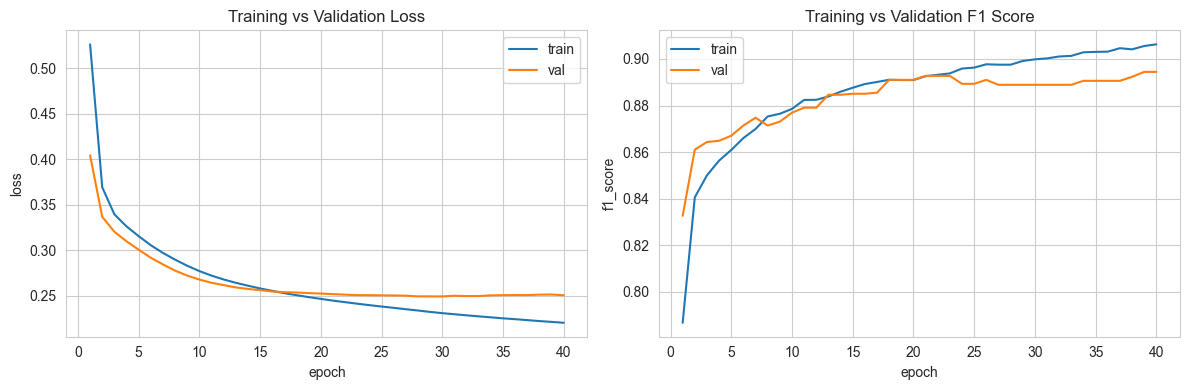

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
Precision: 0.853
Recall:    0.928
F1 Score:  0.889
ROC AUC:   0.964


(0.8529411764705882, 0.928, 0.8888888888888888, 0.9641919999999999)

In [14]:
# Architecture Exploration

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

configs = [
    (L, U, A)
    for L in (1,2,3)
    for U in (8,16,32,64)
    for A in ('relu', 'tanh')
]

best = None

for L, U, A in configs:
    model = build_model(input_dim=input_dim, layer_units=[U]*L, activation=A)
    history = model.fit(
        Xtr, y_train,
        validation_data=(Xva, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    prec, rec, f1, auc = evaluate_model(model, Xva, y_val)

    if (best is None) or (f1 > best['f1']) or (f1 == best['f1'] and auc > best['roc_auc']):
        best = {'layers': L, 'units': U, 'activation': A,
                'f1': f1, 'roc_auc': auc, 'history': history, 'model': model}
        
print(f"Best config: layers={best['layers']}, units={best['units']}, activation={best['activation']}")
plot_history(best['history'])
evaluate_model(best['model'], Xva, y_val)


**Overfitting or Underfitting**

The model does not underfit or overfit. This is because the training and validation losses are low and similar, F1 curves converge closely, and validation metrics are high.
If it were to overfit, the validation loss would be much higher/rising while training loss falls.
If it were to underfit, losses for both would remain high, and f1 scores would be lower.

**Observations**

- The best architecture used 2 hidden layers with 16 units each and the ReLU activation (this may differ for each run)
- ReLU consistently performed better than tanh
- Adding more layers generally improved performance

## Regularization

Baseline Model (No Regularization)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.8044 - loss: 0.4837 - val_f1_score: 0.8588 - val_loss: 0.3467
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - f1_score: 0.8442 - loss: 0.3518 - val_f1_score: 0.8671 - val_loss: 0.3119
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - f1_score: 0.8584 - loss: 0.3286 - val_f1_score: 0.8774 - val_loss: 0.2927
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - f1_score: 0.8651 - loss: 0.3115 - val_f1_score: 0.8752 - val_loss: 0.2785
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - f1_score: 0.8715 - loss: 0.2980 - val_f1_score: 0.8731 - val_loss: 0.2697
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - f1_score: 0.8768 - loss: 0.2880 - val_f1_score: 0.8779 - val_loss: 0.2631
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - f1_score: 0.8798 - loss: 0.2797 - val_f1_score: 0.8795 - val_loss: 0.2583
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 869us

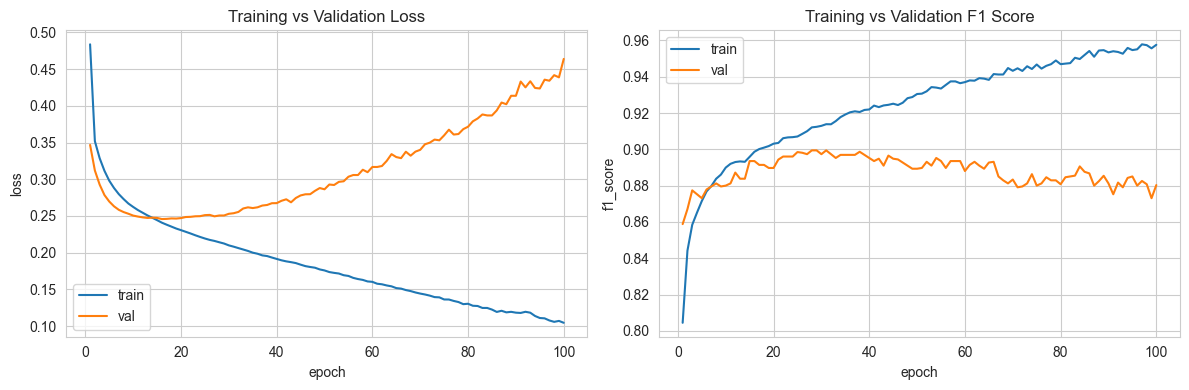

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.851
Recall:    0.912
F1 Score:  0.880
ROC AUC:   0.950

L2 Regularization Tests

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.7891 - loss: 0.6044 - val_f1_score: 0.8593 - val_loss: 0.4594
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - f1_score: 0.8436 - loss: 0.4479 - val_f1_score: 0.8691 - val_loss: 0.4069
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.8553 - loss: 0.4142 - val_f1_score: 0.8669 - val_loss: 0.3817
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - f1_score: 0.8657 - loss: 0.3938 - val_f1_score: 0.8776 - val_loss: 0.3672
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - f1_score: 0.8692 - loss: 0.3796 - val_f1_score: 0.8843 - val_loss: 0.3516
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - f1_score: 0.8706 - loss: 0.3679 - val_f1_score: 0.8855 - val_loss: 0.3414
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - f1_score: 0.8740 - loss: 0.

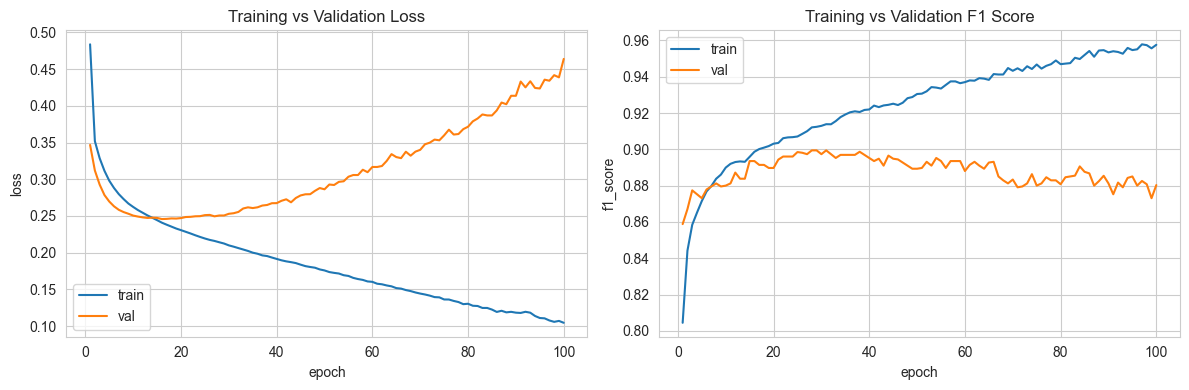

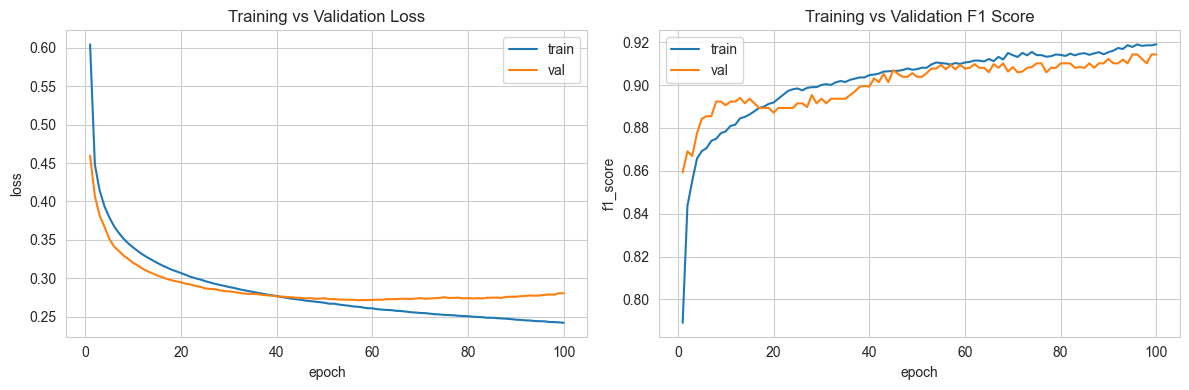


Baseline(Top) vs Best L2 Model(Bottom)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
Precision: 0.873
Recall:    0.960
F1 Score:  0.914
ROC AUC:   0.968

Dropout Tests

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.7123 - loss: 0.5908 - val_f1_score: 0.8114 - val_loss: 0.4086
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - f1_score: 0.8182 - loss: 0.4190 - val_f1_score: 0.8544 - val_loss: 0.3422
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - f1_score: 0.8348 - loss: 0.3845 - val_f1_score: 0.8621 - val_loss: 0.3258
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - f1_score: 0.8430 - loss: 0.3600 - val_f1_score: 0.8659 - val_loss: 0.3121
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - f1_score: 0.8456 - loss: 0.3521 - val_f1_score: 0.8702 - val_loss: 0.3067
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - f1_score: 0.8523 - loss: 0.3403 - val_f1_score: 0.8726 - val_loss: 0.2972
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/

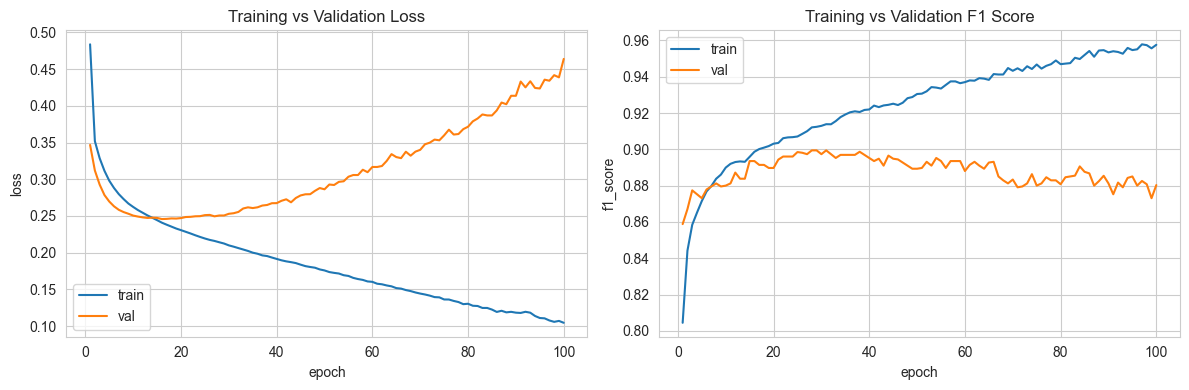

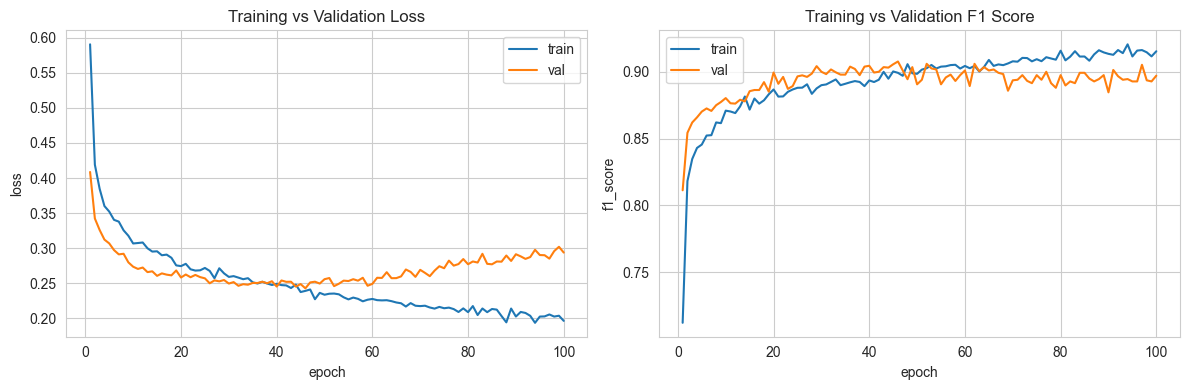


Baseline(top) vs Best Dropout Model(Bottom)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Precision: 0.872
Recall:    0.924
F1 Score:  0.897
ROC AUC:   0.953


(0.8716981132075472, 0.924, 0.8970873786407767, 0.95336)

In [15]:
# Overfitting baseline

print("Baseline Model (No Regularization)\n")
model_overfit = build_model(input_dim=input_dim, layer_units=[128, 64, 32])
history_overfit = train_model(model_overfit, Xtr, y_train, Xva, y_val, epochs=100)
plot_history(history_overfit)
evaluate_model(model_overfit, Xva, y_val)

# L2 penalty

best_l2 = None

print("\nL2 Regularization Tests\n")
for lam in (0.001, 0.0001):
    model_l2 = keras.Sequential()
    model_l2.add(keras.Input(shape=(input_dim,)))

    for units in [128, 64, 32]:
        model_l2.add(keras.layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(lam)))
    
    model_l2.add(keras.layers.Dense(1, activation='sigmoid'))
    model_l2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[PRIMARY_METRIC]
    )

    history_l2 = train_model(model_l2, Xtr, y_train, Xva, y_val, epochs=100)
    prec, rec, f1, auc = evaluate_model(model_l2, Xva, y_val)

    if not best_l2 or f1 > best_l2['f1']:
        best_l2 = {'lam': lam, 'history': history_l2, 'model': model_l2, 'f1': f1, 'auc': auc}

plot_history(history_overfit)
plot_history(best_l2['history'])
print("\nBaseline(Top) vs Best L2 Model(Bottom)\n")
evaluate_model(best_l2['model'], Xva, y_val)

best_do = None

print("\nDropout Tests\n")
for rate in (0.25, 0.5):
    model_do = keras.Sequential()
    model_do.add(keras.Input(shape=(input_dim,)))

    for i, units in enumerate([128, 64, 32]):
        model_do.add(keras.layers.Dense(units, activation='relu'))
        if i < 2:
            model_do.add(keras.layers.Dropout(rate))

    model_do.add(keras.layers.Dense(1, activation='sigmoid'))
    model_do.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[PRIMARY_METRIC]
    )

    history_do = train_model(model_do, Xtr, y_train, Xva, y_val, epochs=100)
    prec, rec, f1, auc = evaluate_model(model_do, Xva, y_val)

    if not best_do or f1 > best_do['f1']:
        best_do = {'rate': rate, 'history': history_do, 'model': model_do, 'f1': f1, 'auc': auc}

plot_history(history_overfit)
plot_history(best_do['history'])
print("\nBaseline(top) vs Best Dropout Model(Bottom)\n")
evaluate_model(best_do['model'], Xva, y_val)



**L2 Regularization** 

L2 weight penalties were applied to reduce model complexity and discourage large parameter values. Regularized models exhibited smoother learning curves and improved validation stability, though excessive regularization reduced model capacity.

**Dropout**

Dropout was applied to randomly deactivate units during training, forcing the network to learn more robust representations. Compared to L2 regularization, dropout more effectively delayed the onset of overfitting and improved generalization in deeper architectures.

**Observations**

- Overfitting occured later for both regularized models compared to the baseline.
- Dropout rate with rate as 0.25 was the most effective for mitigating overfitting.

Overall, it took more epochs before overfitting became visible, and in some cases, no clear overfitting appeared within 100 epochs.


### Model Evaluation

In [16]:
# Best model selection

print("Best Model: Dropout 0.25 (3 layers: [128, 64, 32], ReLU)\n")

best_model = keras.Sequential([
    keras.Input(shape=(input_dim,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

best_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[PRIMARY_METRIC]
)

history_best = best_model.fit(
    np.concatenate((Xtr, Xva)), np.concatenate((y_train, y_val)),
    epochs=100,
    batch_size=32,
    verbose=0
)

evaluate_model(best_model, Xte, y_test)

Best Model: Dropout 0.25 (3 layers: [128, 64, 32], ReLU)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.890
Recall:    0.876
F1 Score:  0.883
ROC AUC:   0.952


(0.8902439024390244, 0.876, 0.8830645161290323, 0.952144)

The best-performing architecture, including regularization where appropriate,
was evaluated on a held-out test set. Performance was assessed using precision,
recall, F1-score, and ROC/AUC.

Test results closely matched validation performance, indicating strong
generalization.

**Comparison with Classical Models**

The deep learning model achieved higher validation performance than classical models evaluated in the previous notebook, demonstrating its ability to capture nonlinear feature interactions.

However, the performance improvement wasn't drastic, highlighting that deep learning is most advantageous when sufficient data complexity justifies its increased capacity.

### Summary

This analysis demonstrated how neural network performance evolves with increasing model complexity and how overfitting can be effectively controlled using early stopping and regularization techniques. Among the methods tested, dropout provided the strongest improvement in generalization.

While deep learning modestly outperformed classical models on this dataset, the results reinforce the importance of principled model selection and regularization over raw model complexity.
